In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
vgg16 = tf.keras.applications.vgg16.VGG16()

553467904/553467096 [==============================] - 7s 0us/step


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential()
for layer in vgg16.layers:
    model.add(layer)

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [7]:
model.layers.pop()

In [8]:
for layer in model.layers:
    layer.trainable = False

In [9]:
model.add(Dense(1, activation='sigmoid'))

In [18]:
optimizer = Adam(lr=0.01)
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])  

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import CSVLogger

training_data_dir = "data/data"
# validation_data_dir = "data/"
# test_data_dir = "data/test"

# Hyperparams
IMAGE_SIZE = 224
IMAGE_WIDTH, IMAGE_HEIGHT = IMAGE_SIZE, IMAGE_SIZE
EPOCHS = 40
BATCH_SIZE = 16
input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 3)

# Data augmentation
training_data_generator = ImageDataGenerator(rescale=1./255, horizontal_flip=True, vertical_flip=True, validation_split=0.2)

# Data preparation
training = training_data_generator.flow_from_directory(
    training_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="training", seed=4)

validation = training_data_generator.flow_from_directory(
    training_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation", seed=4)

Found 12565 images belonging to 2 classes.
Found 3140 images belonging to 2 classes.


In [20]:
model.fit_generator(
    training,
    steps_per_epoch=len(training.filenames) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation,
    validation_steps=len(validation.filenames) // BATCH_SIZE,
    callbacks=[CSVLogger("training_log_vgg16.csv", append=False, separator=",")], 
    verbose=1)

Epoch 1/40
785/785 [==============================] - 251s 320ms/step - loss: 0.6182 - accuracy: 0.7932 - val_loss: 0.5503 - val_accuracy: 0.8607
Epoch 2/40
785/785 [==============================] - 258s 329ms/step - loss: 0.5277 - accuracy: 0.8432 - val_loss: 0.4728 - val_accuracy: 0.8677
Epoch 3/40
785/785 [==============================] - 259s 330ms/step - loss: 0.4731 - accuracy: 0.8494 - val_loss: 0.4253 - val_accuracy: 0.8673
Epoch 4/40
785/785 [==============================] - 259s 330ms/step - loss: 0.4361 - accuracy: 0.8498 - val_loss: 0.3936 - val_accuracy: 0.8712
Epoch 5/40
785/785 [==============================] - 262s 334ms/step - loss: 0.4131 - accuracy: 0.8499 - val_loss: 0.3726 - val_accuracy: 0.8715
Epoch 6/40
785/785 [==============================] - 262s 333ms/step - loss: 0.3939 - accuracy: 0.8536 - val_loss: 0.3608 - val_accuracy: 0.8756
Epoch 7/40
785/785 [==============================] - 259s 330ms/step - loss: 0.3812 - accuracy: 0.8554 - val_loss: 0.3438 -

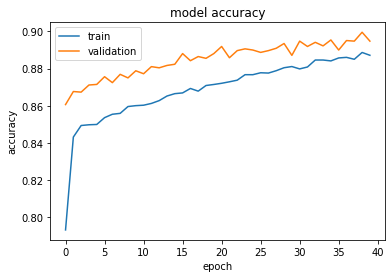

In [21]:
from matplotlib import pyplot as plt
import numpy as np
import itertools

plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

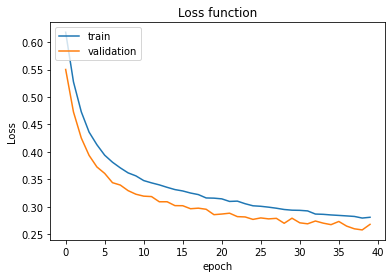

In [22]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Loss function')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [23]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    """
    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions
    """

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [24]:
validation_ = training_data_generator.flow_from_directory(
    training_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=1,
    class_mode="binary",
    shuffle=False,
    subset="validation", seed=4)

Found 3140 images belonging to 2 classes.


In [26]:
probabilities = model.predict_generator(validation_, verbose=1, steps=3140)

Instructions for updating:
Please use Model.predict, which supports generators.
3140/3140 [==============================] - 53s 17ms/step


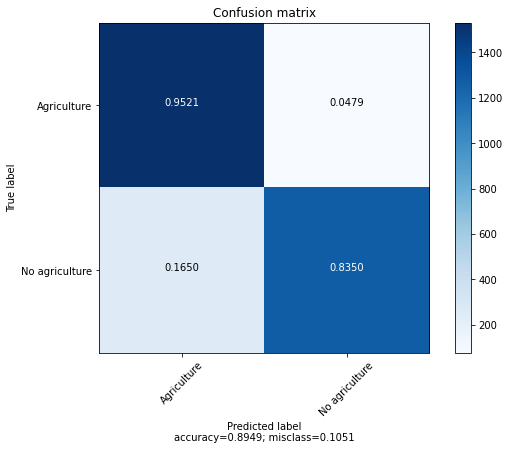

In [27]:
from sklearn.metrics import confusion_matrix
expected = validation.classes
predicted = np.round(probabilities)
results = confusion_matrix(expected, predicted[:,0])
labels = ['Agriculture', 'No agriculture']

plot_confusion_matrix(results, labels)